In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
from scipy.optimize import minimize

In [2]:
df = pd.read_csv('../data/online_data_for_matlab.csv')

In [3]:
# --- 0) paths & imports ---
STAN_FILE = "../data/stan_hybrid_rlm.stan"   # keep as-is if your .stan file is here

import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel

# --- 1) build Stan data from your df (MATLAB-style filtering) ---
def build_stan_data_from_df(df, t_common=0.7):
    required = {'subject_id','trial','choice_1','choice_2','reward','state'}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"df is missing columns: {sorted(missing)}")

    subjects = list(pd.unique(df['subject_id']))
    S = len(subjects)

    C1, C2, R, S2, PC, T = [], [], [], [], [], []

    for sid in subjects:
        sub = df[df['subject_id'] == sid].copy()

        # keep only 'real' trials if that column exists
        if 'practice_trial' in sub.columns:
            vals = sub['practice_trial'].astype(str).str.lower()
            if 'real' in set(vals.unique()):
                sub = sub[vals == 'real']

        sub = sub.sort_values('trial').reset_index(drop=True)

        # prior choice = 9th row (fallback 8th), else default 1
        prior_choice = 1
        if len(sub) >= 9:
            pc9 = int(sub.loc[8,'choice_1']) if pd.notna(sub.loc[8,'choice_1']) else 0
            if pc9 in (1,2):
                prior_choice = pc9
            elif len(sub) >= 8:
                pc8 = int(sub.loc[7,'choice_1']) if pd.notna(sub.loc[7,'choice_1']) else 0
                if pc8 in (1,2):
                    prior_choice = pc8

        # drop first 9 by position (MATLAB choice1(10:end))
        sub = sub.iloc[9:].copy()

        # drop misses / NaNs and keep valid codes
        sub = sub.dropna(subset=['choice_1','choice_2','state','reward'])
        sub = sub[(sub['choice_1'].isin([1,2])) &
                  (sub['choice_2'].isin([1,2])) &
                  (sub['state'].isin([1,2,3])) &
                  (sub['choice_1'] != 0) &
                  (sub['choice_2'] != 0) &
                  (sub['state'] != 0)]

        T_s = len(sub)
        T.append(T_s)
        PC.append(int(prior_choice))
        C1.append(sub['choice_1'].astype(int).to_list())
        C2.append(sub['choice_2'].astype(int).to_list())
        R.append(sub['reward'].astype(float).to_list())
        S2.append(sub['state'].astype(int).to_list())

    T_max = max(T) if len(T) else 1

    # pad to S x T_max for Stan
    c1 = np.ones((S, T_max), dtype=int)
    c2 = np.ones((S, T_max), dtype=int)
    r  = np.zeros((S, T_max), dtype=float)
    s2 = np.ones((S, T_max), dtype=int) * 2  # valid default (state 2)
    for i in range(S):
        n = T[i]
        if n > 0:
            c1[i,:n] = np.array(C1[i], dtype=int)
            c2[i,:n] = np.array(C2[i], dtype=int)
            r[i,:n]  = np.array(R[i],  dtype=float)
            s2[i,:n] = np.array(S2[i], dtype=int)

    data = {
        'S': S,
        'T_max': int(T_max),
        'T': np.array(T, dtype=int),
        'c1': c1,
        'c2': c2,
        'r':  r,
        's2raw': s2,
        'prior_choice': np.array(PC, dtype=int),
        't_common': float(t_common),
    }
    return subjects, data

# --- 2) build data ---
subjects, stan_data = build_stan_data_from_df(df, t_common=0.7)
print(f"Subjects: {len(subjects)} | Max trials: {int(stan_data['T_max'])}")

# --- 3) COMPILE & MAP (this is the Stan run) ---
mod = CmdStanModel(stan_file=STAN_FILE)   # compiles if needed
fit_map = mod.optimize(data=stan_data)    # L-BFGS (MAP)

# --- 4) collect per-subject parameters (ROBUST EXTRACTOR: fixes 'alpha' KeyError) ---
pars = fit_map.optimized_params_dict

def extract_vector(pars, base, S):
    """
    Return an array of length S for parameter 'base'.
    Works for both 'base' and 'base[1]'... styles.
    """
    if base in pars:  # vector form
        v = np.atleast_1d(np.array(pars[base], dtype=float)).reshape(-1)
        if v.size == S:
            return v
    idx_keys = [f"{base}[{i}]" for i in range(1, S+1)]
    if all(k in pars for k in idx_keys):
        return np.array([float(pars[k]) for k in idx_keys], dtype=float)
    dot_keys = [f"{base}.{i}" for i in range(1, S+1)]
    if all(k in pars for k in dot_keys):
        return np.array([float(pars[k]) for k in dot_keys], dtype=float)
    raise KeyError(f"Couldn't find '{base}' in optimized params. "
                   f"Got keys like: {sorted(pars.keys())[:15]} ...")

S = len(subjects)
alpha      = extract_vector(pars, 'alpha',     S)
lam        = extract_vector(pars, 'lambda_',   S)
beta_mb    = extract_vector(pars, 'beta_mb',   S)
beta_mf    = extract_vector(pars, 'beta_mf',   S)
beta2      = extract_vector(pars, 'beta2',     S)
stickiness = extract_vector(pars, 'stickiness',S)

# Derived (GQ isn't run by optimize(), so compute here)
beta1_stage1 = beta_mb + beta_mf
w_hybrid     = beta_mb / np.clip(beta1_stage1, 1e-12, None)

df_params = pd.DataFrame({
    'subject_id'   : subjects,
    'trials_used'  : np.array(stan_data['T'], dtype=int),
    'alpha'        : alpha,
    'lambda'       : lam,
    'beta_mb'      : beta_mb,
    'beta_mf'      : beta_mf,
    'beta2'        : beta2,
    'stickiness'   : stickiness,
    'beta1_stage1' : beta1_stage1,
    'w_hybrid'     : w_hybrid,
})

print(df_params.head(10))


/Users/oguz/Desktop/thesis-project/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
15:46:00 - cmdstanpy - INFO - compiling stan file /Users/oguz/Desktop/thesis-project/data/stan_hybrid_rlm.stan to exe file /Users/oguz/Desktop/thesis-project/data/stan_hybrid_rlm


Subjects: 151 | Max trials: 191


15:46:13 - cmdstanpy - INFO - compiled model executable: /Users/oguz/Desktop/thesis-project/data/stan_hybrid_rlm
15:46:13 - cmdstanpy - INFO - Chain [1] start processing
15:46:16 - cmdstanpy - INFO - Chain [1] done processing


  subject_id  trials_used     alpha    lambda   beta_mb   beta_mf     beta2  \
0       sub1          191  0.456241  0.262775  4.104620  2.787560  6.510260   
1      sub10          191  0.534903  0.033305  0.401606  0.250513  2.098630   
2     sub100          183  0.233753  0.016720  1.037470  2.021400  1.459330   
3     sub101          191  0.861719  0.021106  1.321300  3.015130  2.288070   
4     sub102          146  0.058079  0.055663  1.590530  4.183850  1.653780   
5     sub103          177  0.800973  0.047588  1.590830  4.079950  0.306763   
6     sub104          191  0.745057  0.014116  6.196250  2.649990  5.553540   
7     sub105          191  0.629131  0.063164  2.693960  1.668200  4.372100   
8     sub106          183  0.000965  0.399454  2.003450  1.969310  1.927110   
9     sub107          190  0.525715  0.232781  1.188940  1.106300  2.898960   

   stickiness  beta1_stage1  w_hybrid  
0   -0.038290      6.892180  0.595547  
1   -0.093842      0.652119  0.615848  
2    0.938

In [4]:
from IPython.display import display
display(df_params)

,subject_id,trials_used,alpha,lambda,beta_mb,beta_mf,beta2,stickiness,beta1_stage1,w_hybrid
0,sub1,191,0.456241,0.262775,4.104620,2.787560,6.51026,-0.038290,6.892180,0.595547
1,sub10,191,0.534903,0.033305,0.401606,0.250513,2.09863,-0.093842,0.652119,0.615848
2,sub100,183,0.233753,0.016720,1.037470,2.021400,1.45933,0.938978,3.058870,0.339168
3,sub101,191,0.861719,0.021106,1.321300,3.015130,2.28807,2.263330,4.336430,0.304698
4,sub102,146,0.058079,0.055663,1.590530,4.183850,1.65378,-0.579408,5.774380,0.275446
...,...,...,...,...,...,...,...,...,...,...
146,sub95,190,0.204203,0.915633,2.876240,2.151460,4.76783,1.250590,5.027700,0.572079
147,sub96,184,0.218614,0.017845,1.241350,1.423410,1.24121,-0.715821,2.664760,0.465839
148,sub97,186,0.828052,0.153851,2.702140,1.109440,1.59229,0.726680,3.811580,0.708929
149,sub98,191,0.174927,0.154143,2.078320,2.032900,4.74630,1.300720,4.111220,0.505524


In [5]:
# --- paths & imports ---
STAN_FILE = "hybrid_rl_ddm.stan"

import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel

# -------- settings you can tweak --------
LOWER_RT_SEC = 0.08   # drop RTs below 80 ms as implausible
UPPER_RT_SEC = 15.0   # drop RTs above 15 s as implausible
TER_FLOOR    = 1e-6   # Ter lower bound to match Stan constraint

# ---------- helpers ----------
def extract_vector(pars: dict, base: str, S: int) -> np.ndarray:
    if base in pars:
        v = np.atleast_1d(np.array(pars[base], dtype=float))
        return v.reshape(-1)
    idx_keys = [f"{base}[{i}]" for i in range(1, S+1)]
    if all(k in pars for k in idx_keys):
        return np.array([float(pars[k]) for k in idx_keys], dtype=float)
    dot_keys = [f"{base}.{i}" for i in range(1, S+1)]
    if all(k in pars for k in dot_keys):
        return np.array([float(pars[k]) for k in dot_keys], dtype=float)
    raise KeyError(f"Param '{base}' not found. Keys: {list(pars.keys())[:20]} ...")

def to_seconds_per_trial(rt_series: pd.Series) -> np.ndarray:
    """If value > 20, treat as ms -> divide by 1000; else treat as seconds."""
    x = rt_series.astype(float).values
    secs = np.where(x > 20.0, x / 1000.0, x)
    return secs

# ---------- data builder for two-step RL-DDM (stage-2) ----------
def build_stan_data_from_df_rlddm(df, t_common=0.7):
    required = {'subject_id','trial','choice_1','choice_2','state','reward','rt_2'}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"df is missing columns: {sorted(missing)}")

    subjects = list(pd.unique(df['subject_id']))
    S = len(subjects)

    C1, C2, R, S2, RT2, PC, T = [], [], [], [], [], [], []
    TRIAL_IDS = []

    dropped_tiny, dropped_huge = 0, 0

    for sid in subjects:
        sub = df[df['subject_id'] == sid].copy()

        if 'practice_trial' in sub.columns:
            vals = sub['practice_trial'].astype(str).str.lower()
            if 'real' in set(vals.unique()):
                sub = sub[vals == 'real']

        sub = sub.sort_values('trial').reset_index(drop=True)

        # prior choice from 9th row (fallback 8th), else default 1
        prior_choice = 1
        if len(sub) >= 9:
            pc9 = int(sub.loc[8,'choice_1']) if pd.notna(sub.loc[8,'choice_1']) else 0
            if pc9 in (1,2):
                prior_choice = pc9
            elif len(sub) >= 8:
                pc8 = int(sub.loc[7,'choice_1']) if pd.notna(sub.loc[7,'choice_1']) else 0
                if pc8 in (1,2):
                    prior_choice = pc8

        # drop first 9 by position (warm-up)
        sub = sub.iloc[9:].copy()

        # enforce valid codes & non-missing
        sub = sub.dropna(subset=['choice_1','choice_2','state','reward','rt_2'])
        sub = sub[(sub['choice_1'].isin([1,2])) &
                  (sub['choice_2'].isin([1,2])) &
                  (sub['state'].isin([1,2,3])) &
                  (sub['choice_1'] != 0) &
                  (sub['choice_2'] != 0) &
                  (sub['state'] != 0)]

        # per-trial unit fix to seconds
        sub['rt2_sec'] = to_seconds_per_trial(sub['rt_2'])

        # filter implausible RTs
        before = len(sub)
        sub = sub[(sub['rt2_sec'] >= LOWER_RT_SEC) & (sub['rt2_sec'] <= UPPER_RT_SEC)]
        after = len(sub)
        # crude split of how many were too small vs too large
        dropped_tiny += np.sum(to_seconds_per_trial(df.loc[sub.index, 'rt_2']) < LOWER_RT_SEC) if before != after else 0
        dropped_huge += np.sum(to_seconds_per_trial(df.loc[sub.index, 'rt_2']) > UPPER_RT_SEC) if before != after else 0

        T_s = len(sub)
        T.append(T_s)
        PC.append(int(prior_choice))
        C1.append(sub['choice_1'].astype(int).to_list())
        C2.append(sub['choice_2'].astype(int).to_list())
        R.append(sub['reward'].astype(float).to_list())
        S2.append(sub['state'].astype(int).to_list())
        RT2.append(sub['rt2_sec'].astype(float).to_list())
        TRIAL_IDS.append(sub['trial'].astype(int).to_list())

    # (optional) quick sanity message
    print(f"Dropped RTs — tiny: {dropped_tiny}, huge: {dropped_huge}")

    T_max = max(T) if len(T) else 1

    # pad to S x T_max for Stan
    c1  = np.ones((S, T_max), dtype=int)
    c2  = np.ones((S, T_max), dtype=int)
    r   = np.zeros((S, T_max), dtype=float)
    s2  = np.ones((S, T_max), dtype=int) * 2
    rt2 = np.ones((S, T_max), dtype=float) * 0.5  # safe positive default

    for i in range(S):
        n = T[i]
        if n > 0:
            c1[i,:n]  = np.array(C1[i],  dtype=int)
            c2[i,:n]  = np.array(C2[i],  dtype=int)
            r[i,:n]   = np.array(R[i],   dtype=float)
            s2[i,:n]  = np.array(S2[i],  dtype=int)
            rt2[i,:n] = np.array(RT2[i], dtype=float)

    data = {
        'S': S,
        'T_max': int(T_max),
        'T': np.array(T, dtype=int),
        'c1': c1,
        'c2': c2,
        'r':  r,
        's2raw': s2,
        'rt2': rt2,                 # **seconds**
        'prior_choice': np.array(PC, dtype=int),
        't_common': float(t_common),
    }
    return subjects, data, TRIAL_IDS

# ---------- reconstruct trial-wise drift v_t from fitted params ----------
def reconstruct_vt(subjects, stan_data, alpha, lam, vmod):
    """
    v_t = vmod * (Q[s2,1] - Q[s2,2]) BEFORE learning on that trial.
    Returns list of arrays (per subject), each length T[s].
    """
    S = len(subjects)
    T = np.array(stan_data['T'], dtype=int)
    c1 = stan_data['c1']
    c2 = stan_data['c2']
    r  = stan_data['r']
    s2raw = stan_data['s2raw']

    vt_list = []
    for s in range(S):
        Q = np.zeros((3,2), dtype=float)  # rows: 0=S1, 1&2=stage-2 states

        vt_s = np.zeros(T[s], dtype=float)
        for t in range(T[s]):
            # map raw state {2,3}->{1,2} rows for 0-based array
            sr = int(s2raw[s, t])
            if sr == 3:
                s2 = 2
            elif sr == 2:
                s2 = 1
            else:
                s2 = 1

            # drift prior to learning
            deltaQ_s2 = Q[s2, 0] - Q[s2, 1]         # Q[s2,1] - Q[s2,2] in 1-based
            vt_s[t] = vmod[s] * deltaQ_s2

            # learning updates (mirror Stan)
            a1 = int(c1[s, t]) - 1
            a2 = int(c2[s, t]) - 1
            rew = float(r[s, t])

            delta_rew   = rew - Q[s2, a2]
            Q[s2, a2]  += alpha[s] * delta_rew

            delta_state = Q[s2, a2] - Q[0, a1]
            Q[0, a1]   += alpha[s] * delta_state + lam[s] * alpha[s] * delta_rew

        vt_list.append(vt_s)
    return vt_list

# =================== FIT PIPELINE ===================
t_common = 0.7
subjects, stan_data, trial_ids = build_stan_data_from_df_rlddm(df, t_common=t_common)
print(f"Subjects: {len(subjects)} | Max trials: {int(stan_data['T_max'])}")

mod = CmdStanModel(stan_file=STAN_FILE)

# Safe inits: Ter below min RT (per subject) with tiny floor
S  = len(subjects)
rt2 = stan_data['rt2']
T   = stan_data['T']
min_rt2 = np.array([rt2[i, :T[i]].min() if T[i] > 0 else 0.5 for i in range(S)])
Ter_init = np.maximum(TER_FLOOR, 0.5 * min_rt2)   # 50% of the subject's minimum RT

inits = {
    'alpha'     : np.full(S, 0.2),
    'lambda_'   : np.full(S, 0.2),
    'beta_mb'   : np.full(S, 1.5),
    'beta_mf'   : np.full(S, 1.5),
    'stickiness': np.zeros(S),
    'vmod'      : np.full(S, 1.0),
    'a'         : np.full(S, 1.5),
    'Ter'       : Ter_init,
    'z'         : np.full(S, 0.5),
}

fit_map = mod.optimize(data=stan_data, inits=inits)

pars = fit_map.optimized_params_dict
alpha      = extract_vector(pars, 'alpha',      S)
lam        = extract_vector(pars, 'lambda_',    S)
beta_mb    = extract_vector(pars, 'beta_mb',    S)
beta_mf    = extract_vector(pars, 'beta_mf',    S)
stickiness = extract_vector(pars, 'stickiness', S)
vmod       = extract_vector(pars, 'vmod',       S)
a          = extract_vector(pars, 'a',          S)
Ter        = extract_vector(pars, 'Ter',        S)
z          = extract_vector(pars, 'z',          S)

beta1_stage1 = beta_mb + beta_mf
w_hybrid     = beta_mb / np.clip(beta1_stage1, 1e-12, None)

df_params = pd.DataFrame({
    'subject_id'   : subjects,
    'trials_used'  : np.array(stan_data['T'], dtype=int),
    'alpha'        : alpha,
    'lambda'       : lam,
    'beta_mb'      : beta_mb,
    'beta_mf'      : beta_mf,
    'stickiness'   : stickiness,
    'vmod'         : vmod,       # drift scaling
    'a'            : a,
    'Ter'          : Ter,        # seconds
    'z'            : z,
    'beta1_stage1' : beta1_stage1,
    'w_hybrid'     : w_hybrid,
})
print("Parameter estimates (head):")
print(df_params.head())

# Trial-wise drifts
vt_per_subject = reconstruct_vt(subjects, stan_data, alpha, lam, vmod)

rows = []
for i, sid in enumerate(subjects):
    Ti = int(stan_data['T'][i])
    for j in range(Ti):
        rows.append({
            'subject_id': sid,
            'trial'     : trial_ids[i][j],
            't_index'   : j + 1,
            'v_t'       : vt_per_subject[i][j],
            'rt2_sec'   : stan_data['rt2'][i, j],
            'choice2'   : stan_data['c2'][i, j],
            'state'     : stan_data['s2raw'][i, j],
            'reward'    : stan_data['r'][i, j],
        })
df_vt = pd.DataFrame(rows)
print("\nTrial-wise v_t (head):")
print(df_vt.head())


Dropped RTs — tiny: 54, huge: 0
Subjects: 151 | Max trials: 191


15:46:29 - cmdstanpy - INFO - Chain [1] start processing
15:47:23 - cmdstanpy - INFO - Chain [1] done processing


Parameter estimates (head):
  subject_id  trials_used     alpha    lambda   beta_mb   beta_mf  stickiness  \
0       sub1          190  0.343418  0.451807  4.449380  2.180300    0.107939   
1      sub10          191  0.323044  0.027796  0.530794  0.505526   -0.098517   
2     sub100          157  0.242641  0.016060  1.058130  3.048490    0.787320   
3     sub101          191  0.796777  0.033012  1.383470  3.150350    2.228120   
4     sub102          142  0.043641  0.083556  1.462290  4.223540   -0.520767   

       vmod        a       Ter         z  beta1_stage1  w_hybrid  
0  3.665730  1.91671  0.232074  0.709574       6.62968  0.671130  
1  1.012760  2.40310  0.362948  0.804962       1.03632  0.512191  
2  0.449243  5.39271  0.066368  0.918669       4.10662  0.257664  
3  1.479300  2.12172  0.198561  0.743068       4.53382  0.305144  
4  0.828588  3.13042  0.074348  0.769920       5.68583  0.257181  

Trial-wise v_t (head):
  subject_id  trial  t_index       v_t   rt2_sec  choice2  

In [6]:
def compute_stage2_v_for_subject(df, subject_id, alpha, lam, vmod):
    """
    Reconstruct trial-wise drift for stage-2: v_t = vmod * (Q[s2,1]-Q[s2,2]),
    using the same TD(λ) updates as in the Stan model.
    """
    sub = df[df['subject_id'] == subject_id].copy()

    if 'practice_trial' in sub.columns:
        vals = sub['practice_trial'].astype(str).str.lower()
        if 'real' in set(vals.unique()):
            sub = sub[vals == 'real']

    sub = sub.sort_values('trial').reset_index(drop=True)
    sub = sub.iloc[9:].copy()  # drop first 9 (Matlab style)
    sub = sub.dropna(subset=['choice_1','choice_2','state','reward'])
    sub = sub[(sub['choice_1'].isin([1,2])) &
              (sub['choice_2'].isin([1,2])) &
              (sub['state'].isin([2,3]))]

    Q = np.zeros((3, 2), dtype=float)  # row0=S1, rows1-2=S2 states

    out = []
    for _, row in sub.iterrows():
        a1 = int(row['choice_1']) - 1
        a2 = int(row['choice_2']) - 1
        r  = float(row['reward'])
        s_raw = int(row['state'])
        s2 = 1 if s_raw == 2 else 2   # 2->row1, 3->row2

        # drift BEFORE updating (matches likelihood timing)
        delta_Q = Q[s2, 0] - Q[s2, 1]
        v_t = vmod * delta_Q

        out.append({
            'subject_id': subject_id,
            'trial'     : int(row['trial']),
            'state'     : s_raw,
            'choice_1'  : int(row['choice_1']),
            'choice_2'  : int(row['choice_2']),
            'reward'    : r,
            'delta_Q'   : float(delta_Q),
            'v_t'       : float(v_t),
            'rt_2'      : float(row['rt_2']) if 'rt_2' in sub.columns else np.nan,
        })

        # TD(λ) updates
        delta_rew   = r - Q[s2, a2]
        Q[s2, a2]  += alpha * delta_rew
        delta_state = Q[s2, a2] - Q[0, a1]
        Q[0, a1]   += alpha * delta_state + lam * alpha * delta_rew

    return pd.DataFrame(out)

# --- example for one subject ---
sid = subjects[0]  # or "sub52" etc.
p   = df_params.loc[df_params['subject_id']==sid].iloc[0]

v_df = compute_stage2_v_for_subject(
    df,
    subject_id=sid,
    alpha=float(p['alpha']),
    lam=float(p['lambda']),
    vmod=float(p['vmod'])
)
print(v_df.head(10))


  subject_id  trial  state  choice_1  choice_2  reward   delta_Q       v_t  \
0       sub1     10      2         1         2     1.0  0.000000  0.000000   
1       sub1     11      3         1         2     0.0  0.000000  0.000000   
2       sub1     12      2         1         2     0.0 -0.343418 -1.258878   
3       sub1     13      2         2         2     0.0 -0.225482 -0.826556   
4       sub1     14      2         1         1     0.0 -0.148047 -0.542702   
5       sub1     15      3         2         2     0.0  0.000000  0.000000   
6       sub1     16      3         2         1     0.0  0.000000  0.000000   
7       sub1     17      2         1         2     1.0 -0.148047 -0.542702   
8       sub1     18      2         1         2     0.0 -0.440623 -1.615206   
9       sub1     19      2         1         1     0.0 -0.289305 -1.060515   

       rt_2  
0   554.385  
1  1334.860  
2   753.220  
3  1374.005  
4  1316.530  
5  1042.005  
6   622.110  
7   758.050  
8   473.935  
9

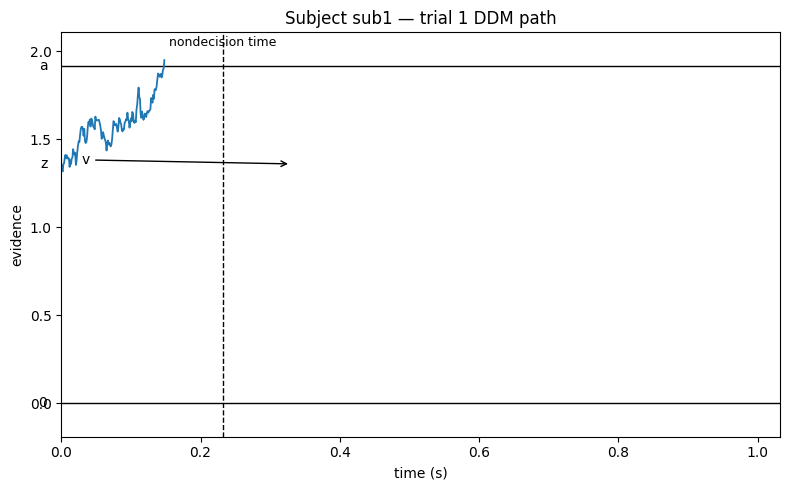

Saved schematic to: ddm_schematic_subjectsub1_trial1.png


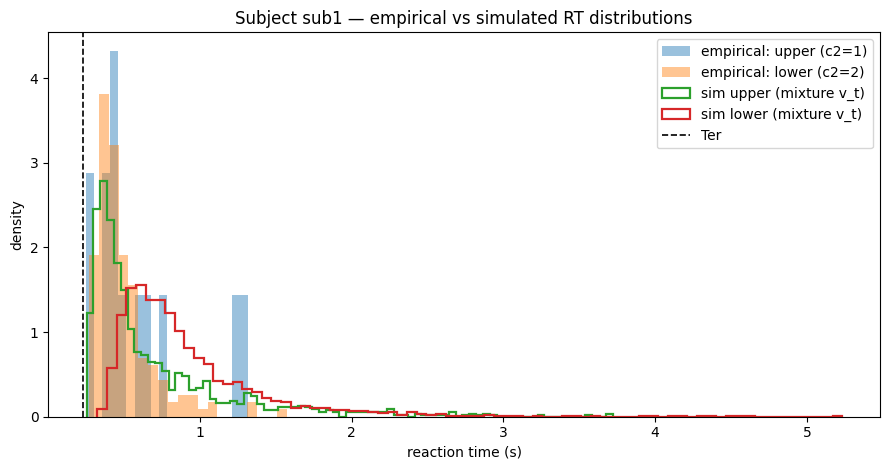

Saved RT distributions to: ddm_empirical_vs_simulated_rts_subjectsub1.png


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# ------------- required fitted objects (will raise if missing) -------------
needed = ["vt_per_subject", "a", "z", "Ter", "subjects", "stan_data"]
missing = [k for k in needed if k not in globals()]
if missing:
    raise RuntimeError(f"Missing in session: {missing}. Fit RLDDM first.")

# pick which subject/trial to visualize
s_idx = 0   # <- change me
t_idx = 0   # <- change me

# bounds checks
S = len(subjects)
if not (0 <= s_idx < S):
    raise IndexError(f"s_idx {s_idx} out of range 0..{S-1}")
Ti = int(stan_data['T'][s_idx])
if Ti == 0:
    raise RuntimeError(f"Subject {subjects[s_idx]} has 0 modeled trials.")
if not (0 <= t_idx < Ti):
    raise IndexError(f"t_idx {t_idx} out of range 0..{Ti-1}")

# pull subject-specific stuff
sid   = subjects[s_idx]
v_ts  = np.asarray(vt_per_subject[s_idx], dtype=float)   # trial-wise drift for subject
v     = float(v_ts[t_idx])                               # drift for chosen trial
a_sub = float(np.asarray(a)[s_idx])
z_sub = float(np.asarray(z)[s_idx])
Ter_sub = float(np.asarray(Ter)[s_idx])

# observed RTs & choices (seconds, boundary-coded by c2: 1=upper, 2=lower)
rt2 = np.asarray(stan_data['rt2'][s_idx, :Ti], dtype=float)
c2  = np.asarray(stan_data['c2'][s_idx, :Ti], dtype=int)

# ---------- DDM simulation utilities ----------
def simulate_ddm_rts(v, a, z_frac, Ter, n=3000, dt=0.001, s=1.0, t_max=5.0, rng=None):
    """Euler–Maruyama first-passage times for constant-drift DDM."""
    if rng is None: rng = np.random.default_rng()
    x0 = z_frac * a
    max_steps = int(t_max / dt)
    rts = np.empty(n); choices = np.empty(n, dtype=int)

    batch = min(n, 2000); done = 0
    while done < n:
        m = min(batch, n - done)
        X = np.full(m, x0); alive = np.ones(m, bool)
        t = np.zeros(m); rt_rec = np.full(m, np.nan); ch_rec = np.full(m, -1, int)

        for _ in range(max_steps):
            idx = np.where(alive)[0]
            if idx.size == 0: break
            dW = np.random.normal(0.0, sqrt(dt), size=idx.size)
            X[idx] += v * dt + s * dW; t[idx] += dt

            hit_u = X[idx] >= a; 
            if np.any(hit_u):
                ii = idx[hit_u]; rt_rec[ii] = t[idx][hit_u] + Ter; ch_rec[ii] = 1; alive[ii] = False
            hit_l = X[idx] <= 0.0;
            if np.any(hit_l):
                ii = idx[hit_l]; rt_rec[ii] = t[idx][hit_l] + Ter; ch_rec[ii] = 0; alive[ii] = False

        # fallbacks if no hit before t_max
        still = np.where(alive)[0]
        if still.size:
            rt_rec[still] = t[still] + Ter
            ch_rec[still] = (X[still] >= a/2).astype(int)

        rts[done:done+m] = rt_rec; choices[done:done+m] = ch_rec; done += m
    return rts, choices

def simulate_mixture_over_trials(v_series, a, z_frac, Ter, n=5000, dt=0.001, rng=None):
    """Mixture of constant-drift DDMs by sampling a trial-wise v_t each run."""
    if rng is None: rng = np.random.default_rng()
    v_series = np.asarray(v_series, float)
    rts = []; chs = []
    # run in chunks to keep it quick
    chunk = 500
    for _ in range(int(np.ceil(n/chunk))):
        draws = v_series[rng.integers(0, len(v_series), size=chunk)]
        rt_chunk = []; ch_chunk = []
        for vv in draws:
            rt, ch = simulate_ddm_rts(vv, a, z_frac, Ter, n=1, dt=dt, rng=rng)
            rt_chunk.append(rt[0]); ch_chunk.append(ch[0])
        rts.extend(rt_chunk); chs.extend(ch_chunk)
    return np.array(rts), np.array(chs, int)

# ---------- FIGURE 1: single-trial schematic ----------
def draw_ddm_schematic(v, a, z_frac, Ter, dt=0.001, t_max=3.0, path=None):
    rng = np.random.default_rng(123)
    x0 = z_frac * a
    max_steps = int(t_max / dt)
    X, T = [x0], [0.0]
    for _ in range(max_steps):
        dW = rng.normal(0.0, sqrt(dt))
        X.append(X[-1] + v * dt + 1.0 * dW)
        T.append(T[-1] + dt)
        if X[-1] >= a or X[-1] <= 0.0: break
    dec_time = T[-1]

    plt.figure(figsize=(8, 5))
    plt.axhline(0.0, lw=1.0, color="k"); plt.axhline(a, lw=1.0, color="k")
    plt.axvline(Ter, ls="--", lw=1.0, color="k")
    plt.plot(T, X, lw=1.3)
    # drift arrow
    t0 = min(0.15, T[-1]*0.2); t1 = t0 + 0.3
    plt.annotate("v", xy=(t1, x0 + v*0.3), xytext=(t0, x0),
                 arrowprops=dict(arrowstyle="->", lw=1.0), fontsize=10)
    plt.text(-0.02, a, "a", va="center", ha="right")
    plt.text(-0.02, 0.0, "0", va="center", ha="right")
    plt.text(-0.02, x0, "z", va="center", ha="right")
    plt.text(Ter, a + a*0.06, "nondecision time", ha="center", fontsize=9)
    plt.annotate("decision time", xy=(Ter + dec_time, a + a*0.12), xytext=(Ter, a + a*0.12),
                 arrowprops=dict(arrowstyle="<->", lw=1.0), ha="center", fontsize=9)
    plt.xlabel("time (s)"); plt.ylabel("evidence")
    plt.title(f"Subject {sid} — trial {t_idx+1} DDM path")
    plt.ylim(-a*0.1, a*1.1); plt.xlim(0, Ter + max(dec_time, 0.8))
    plt.tight_layout()
    if path:
        plt.savefig(path, dpi=160)
    plt.show()

schem_path = f"ddm_schematic_subject{sid}_trial{t_idx+1}.png"
draw_ddm_schematic(v, a_sub, z_sub, Ter_sub, path=schem_path)
print("Saved schematic to:", schem_path)

# ---------- FIGURE 2: empirical vs simulated RT distributions ----------
# empirical split by bound (using c2: 1=upper, 2=lower)
emp_u = rt2[c2 == 1]; emp_l = rt2[c2 == 2]

# mixture sim using this subject’s trial-wise v_t
sim_rts, sim_ch = simulate_mixture_over_trials(v_ts, a_sub, z_sub, Ter_sub, n=6000, dt=0.001)

plt.figure(figsize=(9, 4.8))
bins = max(20, int(np.sqrt(rt2.size)))
# empirical
plt.hist(emp_u, bins=bins, density=True, alpha=0.45, label="empirical: upper (c2=1)")
plt.hist(emp_l, bins=bins, density=True, alpha=0.45, label="empirical: lower (c2=2)")
# simulated
bins_sim = max(20, int(np.sqrt(sim_rts.size)))
plt.hist(sim_rts[sim_ch == 1], bins=bins_sim, density=True, histtype="step", linewidth=1.6,
         label="sim upper (mixture v_t)")
plt.hist(sim_rts[sim_ch == 0], bins=bins_sim, density=True, histtype="step", linewidth=1.6,
         label="sim lower (mixture v_t)")
plt.axvline(Ter_sub, ls="--", lw=1.2, color="k", label="Ter")
plt.xlabel("reaction time (s)"); plt.ylabel("density")
plt.title(f"Subject {sid} — empirical vs simulated RT distributions")
plt.legend(); plt.tight_layout()
out_path = f"ddm_empirical_vs_simulated_rts_subject{sid}.png"
plt.savefig(out_path, dpi=160); plt.show()
print("Saved RT distributions to:", out_path)


Saved: ddm_paths_subjectsub1_first12.png


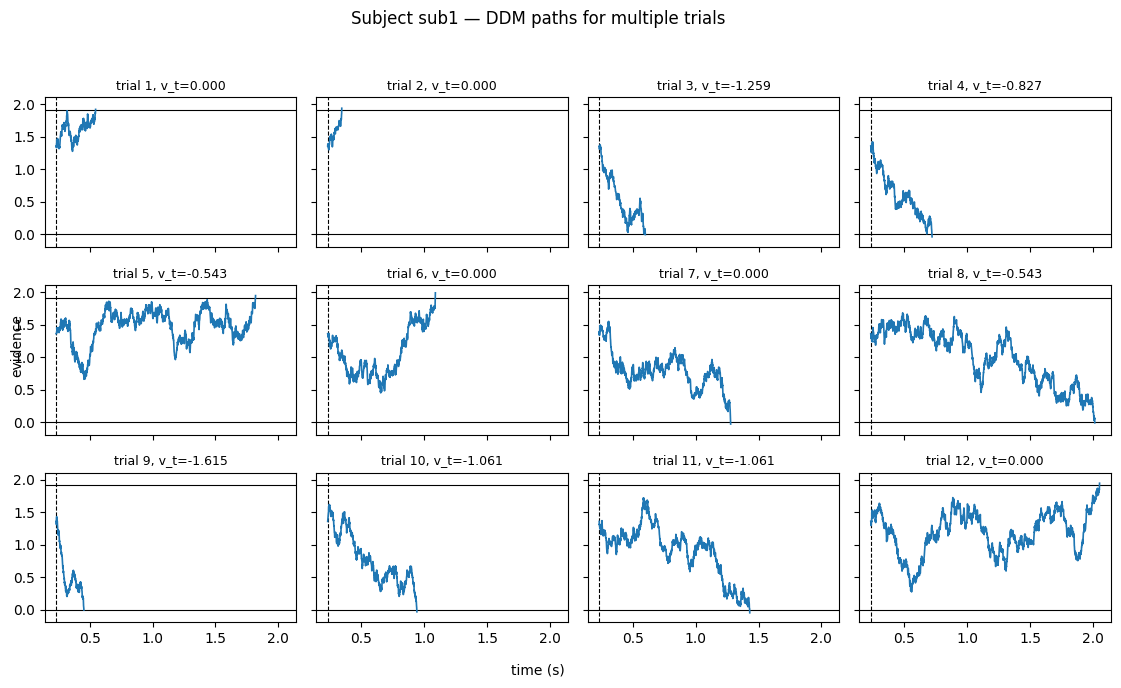

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import os

# ---- util: one stochastic path for a given v ----
def simulate_ddm_path(v, a, z_frac, Ter, dt=0.001, t_max=3.0, s=1.0, seed=None):
    rng = np.random.default_rng(seed)
    x0 = z_frac * a
    X = [x0]; T = [0.0]
    steps = int(t_max / dt)
    for _ in range(steps):
        X.append(X[-1] + v*dt + s*rng.normal(0.0, sqrt(dt)))
        T.append(T[-1] + dt)
        if X[-1] >= a or X[-1] <= 0.0:
            break
    return np.array(T) + Ter, np.array(X)

def plot_trial_grid(subject_index=0, which="first", n_rows=3, n_cols=4,
                    dt=0.001, t_max=3.0, save_path=None):
    S = len(subjects)
    if not (0 <= subject_index < S):
        raise IndexError("subject_index out of range")

    sid   = subjects[subject_index]
    Ti    = int(stan_data['T'][subject_index])
    vts   = np.asarray(vt_per_subject[subject_index], float)
    a_sub = float(np.asarray(a)[subject_index])
    z_sub = float(np.asarray(z)[subject_index])
    Ter_s = float(np.asarray(Ter)[subject_index])

    N = n_rows * n_cols
    idxs = np.arange(Ti)
    if which == "first":
        idxs = idxs[:N]
    elif which == "last":
        idxs = idxs[-N:]
    elif which == "random":
        rng = np.random.default_rng(123)
        idxs = rng.choice(idxs, size=min(N, Ti), replace=False)
    else:
        raise ValueError("which must be 'first', 'last', or 'random'")

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 7), sharex=True, sharey=True)
    axes = np.ravel(axes)

    for k, t_idx in enumerate(idxs):
        Tpath, Xpath = simulate_ddm_path(vts[t_idx], a_sub, z_sub, Ter_s,
                                         dt=dt, t_max=t_max, seed=1000+t_idx)
        ax = axes[k]
        ax.axhline(0.0, lw=0.8, color="k")
        ax.axhline(a_sub, lw=0.8, color="k")
        ax.axvline(Ter_s, ls="--", lw=0.8, color="k")
        ax.plot(Tpath, Xpath, lw=1.2)
        ax.set_title(f"trial {t_idx+1}, v_t={vts[t_idx]:.3f}", fontsize=9)
        ax.set_ylim(-a_sub*0.1, a_sub*1.1)

    # hide unused panels
    for j in range(len(idxs), len(axes)):
        axes[j].axis("off")

    fig.suptitle(f"Subject {sid} — DDM paths for multiple trials", y=0.98)
    fig.text(0.5, 0.03, "time (s)", ha="center")
    fig.text(0.06, 0.5, "evidence", va="center", rotation="vertical")
    fig.tight_layout(rect=[0.05, 0.05, 0.99, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=160)
        print("Saved:", save_path)
    plt.show()

# EXAMPLE: first 12 modeled trials for subject 0
plot_trial_grid(subject_index=0, which="first", n_rows=3, n_cols=4,
                dt=0.001, t_max=3.0,
                save_path=f"ddm_paths_subject{subjects[0]}_first12.png")


In [9]:
# If your current variables are named differently, tweak these two lines:
df_params_rl = df_params_rl if 'df_params_rl' in globals() else df_params_softmax  # <- your RL (softmax) params
df_params_rlddm = df_params_rlddm if 'df_params_rlddm' in globals() else df_params  # <- your RLDDM params

# If you only have generic names:
# df_params_rl = df_params_from_softmax_run
# df_params_rlddm = df_params_from_rlddm_run
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# 1) Select needed columns and rename
rl = df_params_rl.rename(columns={'beta2':'beta2_rl'})[['subject_id','beta2_rl']].copy()
rlddm = (
    df_params_rlddm
    .rename(columns={'vmod':'vmod_rlddm','a':'a_rlddm'})
    [['subject_id','vmod_rlddm','a_rlddm','z','Ter']]
    .copy()
)

# 2) Merge by subject
m = rl.merge(rlddm, on='subject_id', how='inner')
if m.empty:
    raise ValueError("No subject overlap between RL (softmax) and RLDDM tables.")

# 3) Softmax-equivalent slope from RLDDM: beta ≈ 2*a*vmod (s=1)
m['beta_equiv_ddm'] = 2.0 * m['a_rlddm'] * m['vmod_rlddm']

# 4) Correlations
pr = pearsonr(m['beta2_rl'], m['beta_equiv_ddm'])
sr = spearmanr(m['beta2_rl'], m['beta_equiv_ddm'])
print(f"Pearson r = {pr.statistic:.3f} (p={pr.pvalue:.3g})")
print(f"Spearman ρ = {sr.correlation:.3f} (p={sr.pvalue:.3g})")

# 5) Plot
x = m['beta2_rl'].to_numpy()
y = m['beta_equiv_ddm'].to_numpy()
coef = np.polyfit(x, y, 1)

plt.figure(figsize=(6,5))
plt.scatter(x, y, alpha=0.85)
xx = np.linspace(x.min(), x.max(), 200)
plt.plot(xx, coef[0]*xx + coef[1], linewidth=2)
plt.xlabel('Hybrid-RL beta2')
plt.ylabel('RLDDM softmax-equivalent (2 * a * vmod)')
plt.title(f'Pearson r={pr.statistic:.2f}, Spearman ρ={sr.correlation:.2f}')
plt.tight_layout()
plt.show()


NameError: name 'df_params_softmax' is not defined